In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
ROOT_PATH = Path().resolve().parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import rcParams
from frequency_response import FrequencyResponse
from biquad import peaking, low_shelf, high_shelf, digital_coeffs

In [3]:
fns = {'PK': peaking, 'LS': low_shelf, 'HS': high_shelf}
fs = 48000
#f = [20.0]
#while f[-1] < fs:
#    f.append(f[-1]*2**(1/32))
#f = np.array(f)

def peq2fr(fc, q, gain, filts):
    if type(fc) in [float, int]:
        fc = np.array([fc])
    if type(q) in [float, int]:
        q = np.array([q])
    if type(gain) in [float, int]:
        gain = np.array([gain])
    if type(filts) == str:
        filts = [filts] * len(fc)
    fr = FrequencyResponse(name='PEG')
    c = np.zeros(fr.frequency.shape)
    for i, filt in enumerate(filts):
        a0, a1, a2, b0, b1, b2 = fns[filt](fc[i], q[i], gain[i], fs=fs)
        c += digital_coeffs(fr.frequency, fs, a0, a1, a2, b0, b1, b2)
    fr.raw = c
    return fr

No handles with labels found to put in legend.


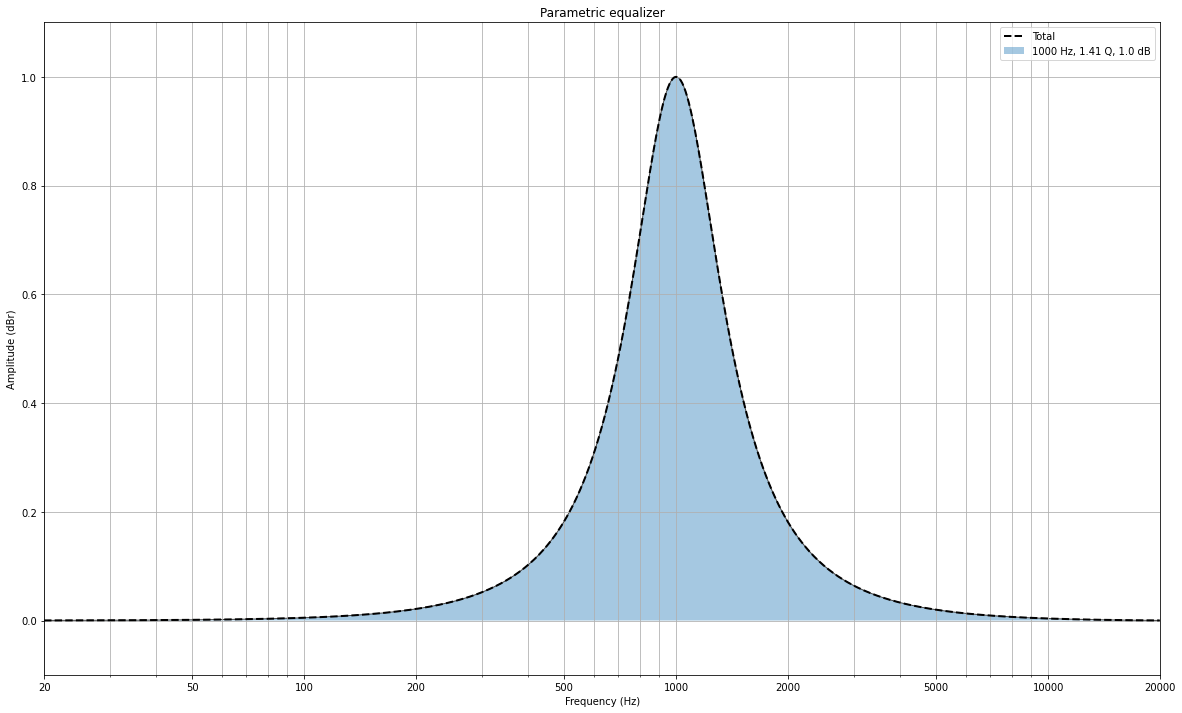

In [5]:
# Stax ST-L300 by Crinacle
#fc = [25, 1146, 4163, 5699, 9683, 198, 2144, 12617, 12788, 19857]
#q = [0.9, 1.69, 1.19, 2.69, 3.19, 1.4, 5.38, 0.94, 1.36, 0.38]
#gain = [6.3, -2.9, 4.6, -5.8, 2.6, -0.9, 0.7, 2.0, 0.8, -10.6]
# Beyerdynamic DT 880 250 Ohm by oratory1990
#fc = [19, 230, 1017, 4596, 7406, 1548, 2070, 3459, 12671, 19698]
#q = [1.29, 0.54, 0.35, 5.26, 2.88, 2.69, 2.27, 3.83, 0.9, 0.4]
#gain = [1.4, -5.0, 3.6, 5.8, -6.5, -1.0, 1.1, -0.7, 3.5, -13.6]
# Beyerdynamic DT 770 80 Ohm by Crinacle
fc = [1000]
q = [1.41]
gain = [1]
filts = ['PK']

fig = None
ax = None
i = 0
frs = []
for _fc, _q, _gain, _filt in zip(fc, q, gain, filts):
    fr = peq2fr(_fc, _q, _gain, _filt)
    frs.append(fr)
    fig, ax = fr.plot_graph(fig=fig, ax=ax, raw_plot_kwargs={'color': '#444444', 'zorder': i*2+1, 'label': None}, show=False)
    label = f'Fc={_fc:.0f} Hz, Q={_q}, Gain={_gain:.1f} dB'
    label = f'{_fc:.0f} Hz, {_q} Q, {_gain:.1f} dB'
    ax.fill_between(fr.frequency, fr.raw, alpha=0.4, zorder=i*2, label=label)
    i += 1
fr = FrequencyResponse(name='Parametric equalizer', frequency=frs[0].frequency, raw=np.sum([_fr.raw for _fr in frs], axis=0))
fr.plot_graph(fig=fig, ax=ax, raw_plot_kwargs={'color': 'black', 'zorder': 11, 'label': 'Total', 'linewidth': 2, 'linestyle': 'dashed'}, show=False)

ymin = np.min(fr.raw)
ymax = np.max(fr.raw)
ydelta = ymax - ymin
ymin -= 0.1 * ydelta
ymax += 0.1 * ydelta
ax.set_ylim([ymin, ymax])
ax.legend()
ax.set_xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000])
fig.set_size_inches(20, 12)
plt.show()

## Impact of Different Sampling Rates on the Frequency Response

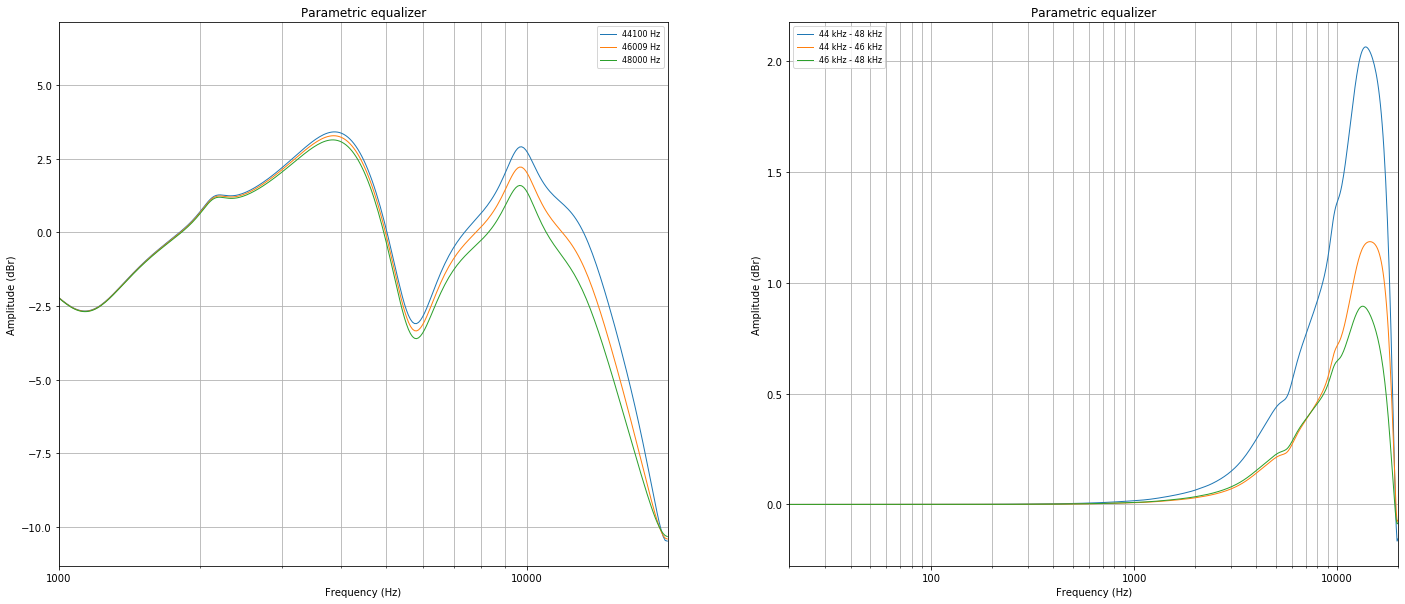

In [46]:
fc = [25, 1146, 4163, 5699, 9683, 198, 2144, 12617, 12788, 19857]
q = [0.9, 1.69, 1.19, 2.69, 3.19, 1.4, 5.38, 0.94, 1.36, 0.38]
gain = [6.3, -2.9, 4.6, -5.8, 2.6, -0.9, 0.7, 2.0, 0.8, -10.6]

fig, axs = plt.subplots(1, 2)
frs = []
for i, fs in enumerate([44100, 44100 * np.sqrt(48/44.1), 48000]):
    _frs = []
    for _fc, _q, _gain, _filt in zip(fc, q, gain, filts):
        _frs.append(peq2fr(_fc, _q, _gain, _filt))
    _fr = FrequencyResponse(name='Parametric equalizer', frequency=_frs[0].frequency, raw=np.sum([_fr.raw for _fr in _frs], axis=0))
    _fr.plot_graph(fig=fig, ax=axs[0], raw_plot_kwargs={'color': f'C{i}', 'label': f'{fs:.0f} Hz'}, show=False)
    frs.append(_fr)
axs[0].set_xlim([1000, 20000])

frs[0].compensate(frs[2])
frs[0].error -= frs[0].error[0]
frs[0].plot_graph(fig=fig, ax=axs[1], raw=False, target=False, error_plot_kwargs={'label': '44 kHz - 48 kHz', 'color': 'C0'}, show=False)
frs[0].compensate(frs[1])
frs[0].error -= frs[0].error[0]
frs[0].plot_graph(fig=fig, ax=axs[1], raw=False, target=False, error_plot_kwargs={'label': '44 kHz - 46 kHz', 'color': 'C1'}, show=False)
frs[1].compensate(frs[2])
frs[1].error -= frs[1].error[0]
frs[1].plot_graph(fig=fig, ax=axs[1], raw=False, target=False, error_plot_kwargs={'label': '46 kHz - 48 kHz', 'color': 'C2'}, show=False)

fig.set_size_inches(24, 10)
plt.show()